# 2. Análise exploratória

Com os dados sanitizados, é possível agora verificar algumas distribuições das variáveis disponíveis, para entender como é o perfil dos clientes e das características dos laboratórios

Com base nestas distribuições, será possível aprofundar as análises, orientando pelas perguntas de negócio que queremos responder

### importando as bibliotecas necessárias

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from scipy.stats import f_oneway

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

%matplotlib inline

### lendo as bases de dados tratadas

In [3]:
demographic_data = pd.read_csv('dados_tratados/demographic_data_trat.csv')
df_geocode = pd.read_csv('dados_tratados/df_geocode_trat.csv')
economic_data = pd.read_csv('dados_tratados/economic_data_trat.csv')
test_data = pd.read_csv('dados_tratados/test_data_trat.csv')
transactional_data = pd.read_csv('dados_tratados/transactional_data_trat.csv')

zipcodes_states = pd.read_excel('dados_brutos/zipcodes-states.xlsx', index_col = 0) # fontes: https://codigo-postal.co/pt-br/eua/, https://pt.wikipedia.org/wiki/Lista_de_estados_dos_Estados_Unidos_por_popula%C3%A7%C3%A3o

C:\Users\Leticia\AppData\Local\Temp\ipykernel_8020\3369382902.py:5: DtypeWarning:

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.



## mapa com a distribuição das localizações

inicialmente, será produzido um mapa dos estados unidos com a localização dos laboratórios

para isso, será utilizada a base df_geocode, que tem as informações de latitude e longitude dos laboratórios 

In [4]:
coordenadas = df_geocode

# separando a latitude e a longitude
coordenadas['latitude'] = coordenadas['Location'].str.split(',').str[0].astype('float')
coordenadas['longitude'] = coordenadas['Location'].str.split(',').str[1].astype('float')

# separando o estado a partir da coluna de endereço
coordenadas['Sigla'] = coordenadas['Address'].str.split(', ').str[2].str.split(' ').str[0]

coordenadas.head()

,Lab Id,Address,Location,Zipcode,latitude,longitude,Sigla
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0,34.000319,-84.162972,GA
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0,43.231133,-75.444536,NY
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0,47.716279,-122.183815,WA
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0,33.909388,-84.352910,GA
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0,40.930993,-90.943760,IL


quais são os estados que têm laboratórios? quantos laboratórios tem em cada um deles?

In [5]:
zipcodes_states.head(3)

,Sigla,Estado,Estado.1,Intervalo de CEPs,Qtd de CEPs,Data de Fundação,População 2020
1,AL,Alabama,Montgomery,35004 to 36925,838,"December 14, 1819",5 024 279
2,AK,Alaska,Juneau,99501 to 99950,274,"January 3, 1959",733 391
3,AZ,Arizona,Phoenix,85001 to 86556,567,"February 14, 1912",7 151 502


In [7]:
estados = coordenadas.groupby('Sigla').count()[['Lab Id']].sort_values('Lab Id', ascending = False).reset_index()

estados = estados.merge(zipcodes_states[['Estado', 'Sigla']], how = 'left')

estados = estados.rename({'Lab Id':'Número de laboratórios'}, axis = 1)

estados

,Sigla,Número de laboratórios,Estado
0,WA,20,Washington
1,CA,18,California
2,GA,18,Georgia
3,PA,17,Pennsylvania
4,MA,12,Massachusetts
5,NY,11,New York
6,IL,6,Illinois
7,IA,5,Iowa
8,NH,4,New Hampshire
9,NJ,3,New Jersey


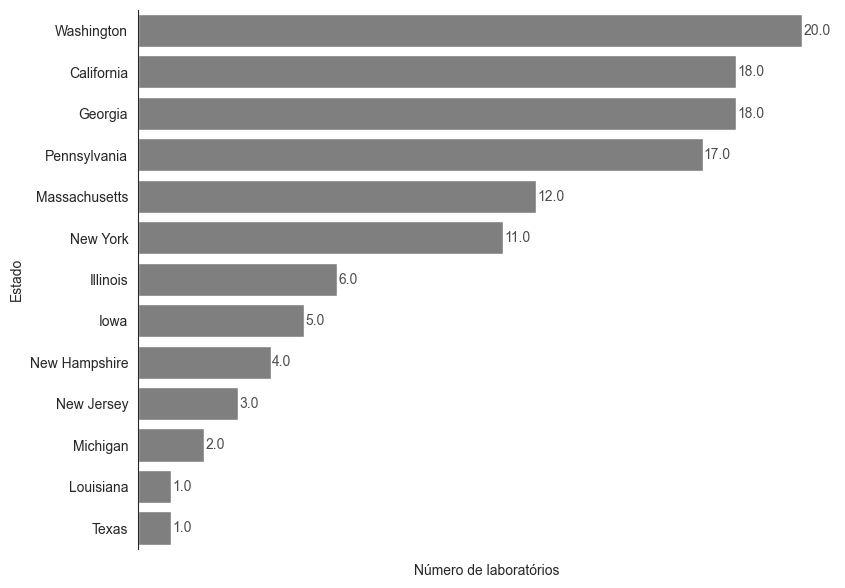

In [8]:
plt.figure(figsize = (9, 7))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = estados, x = 'Número de laboratórios', y = 'Estado', color = '#7f7f7f')

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate(i.get_width(),
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 10,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover o título do eixo x
# fig.set_xlabel('')

# remover os números do eixo x
fig.set_xticklabels('')

# remover as bordas do gráfico
sns.despine(bottom = True)

# deixar o gráfico transparente
# plt.gcf().set_facecolor('none')
# plt.gca().patch.set_alpha(0)

construindo o gráfico de mapa para visualizar as localizações - estão próximos uns dos outros ou mais espalhados pelos EUA?

In [9]:
data = dict(
    type = 'scattergeo',
    # colorscale = 'RdBu',
    lat = coordenadas['latitude'],
    lon = coordenadas['longitude'],
    # locations = coordenadas['state'],
    # locationmode = 'USA-states',
    # z = coordenadas['Lab Id'],
    # text = coordenadas['Address'],
    marker = dict(size = 5, autocolorscale = False, colorscale = 'Bluered', color = coordenadas['Zipcode']),
    # colorbar = dict(title = 'Zipcode')
)

layout = dict(
    title = 'Localizações dos laboratórios',
    geo = dict(scope = 'usa', # showlakes = True, lakecolor = 'rgb(85, 173, 240)',
               projection = dict(type ='albers usa'),showland = True,
                    landcolor="rgb(250,250,250)",subunitcolor = "rgb(100,100,100)",
                     countrycolor = "rgb(100,100,100)",countrywidth =0.5, subunitwidth=0.5)
)

choromap = go.Figure(data = [data], layout = layout)


choromap.update_layout(width=700)
iplot(choromap, validate = False)


observando o mapa, é possível concluir que os laboratórios possuem pequenas concentrações espalhadas pelo país. 

é possível que as unidades estejam próximas para tentar consolidar uma clientela forte nestes locais e para facilitar a logística

## distribuição das variáveis dos clientes

Antes de fazer os gráficos de distribuição, é importante remover os clientes que estão com o final da id "-2" (podem ser pacientes diferentes) e deixar os pacientes como únicos

In [10]:
# remover final_id = -2
pacientes_unicos = transactional_data[transactional_data['final_id'] != '2'].drop_duplicates('Patient Id')

pacientes_unicos['final_id'] = pacientes_unicos['final_id'].astype('str').astype('category')

# número de pacientes únicos
len(pacientes_unicos)

501445

### distribuição de sexo

In [12]:
# gerar tabela para o gráfico de sexo

# agrupar por sexo e contar quantos tem
sexo1 = pacientes_unicos.groupby('Gender').count()['Patient Id'].reset_index()

sexo1 = sexo1.rename({'Patient Id':'Número'}, axis = 1)
sexo1['percentual'] = round(sexo1['Número'] * 100/ len(pacientes_unicos), 1)

sexo1


,Gender,Número,percentual
0,F,341863,68.2
1,M,159582,31.8


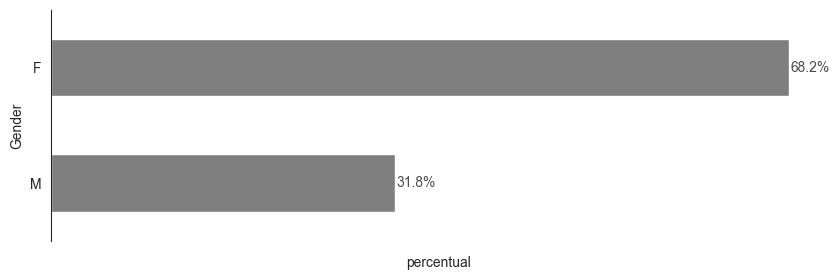

In [13]:
# fazer o gráfico

plt.figure(figsize = (10, 3))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = sexo1, x = 'percentual', y = 'Gender', color = '#7f7f7f', width = 0.5)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate(f"{i.get_width():.1f}%",
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 10,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')

# remover as bordas do gráfico
sns.despine(bottom = True)

# deixar o gráfico transparente
# plt.gcf().set_facecolor('none')
# plt.gca().patch.set_alpha(0)

### histograma de idade

In [14]:
pacientes_unicos.sort_values('Idade', ascending = False).head()

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Valor Pago,Idade,final_id
824591,10225811036-BIO002,M,1859-12-28 00:00:00,2019-09-19,574604575219-67,L152,70004795,264.0,159.0,BIO002
1659547,6162950424-1,F,1900-01-01 00:00:00,2020-04-05,6162950424-1-1,L139,70004461,94.0,120.0,1
156425,10240370370-BIO010,M,1911-08-20 00:00:00,2019-03-03,529400114551-122,L668,70005506,55.0,107.0,BIO010
66737,10240392383-BIO010,M,1911-08-20,2019-02-06,529400111857-122,L668,70005506,55.0,107.0,BIO010
72258,10240388647-BIO010,F,1912-09-07,2019-01-31,529709889235-123,L658,70005506,55.0,106.0,BIO010


<Axes: xlabel='Idade', ylabel='Count'>

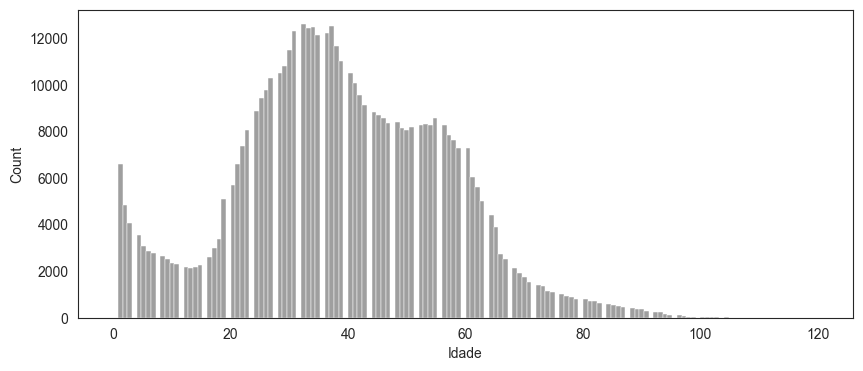

In [15]:
plt.figure(figsize = (10, 4))
sns.set_style('white')
sns.histplot(pacientes_unicos[pacientes_unicos['Idade'] <= 120], x = 'Idade', bins = 150, color = '#7f7f7f')

3. distribuição de sexo + idade

<Axes: xlabel='Idade', ylabel='Count'>

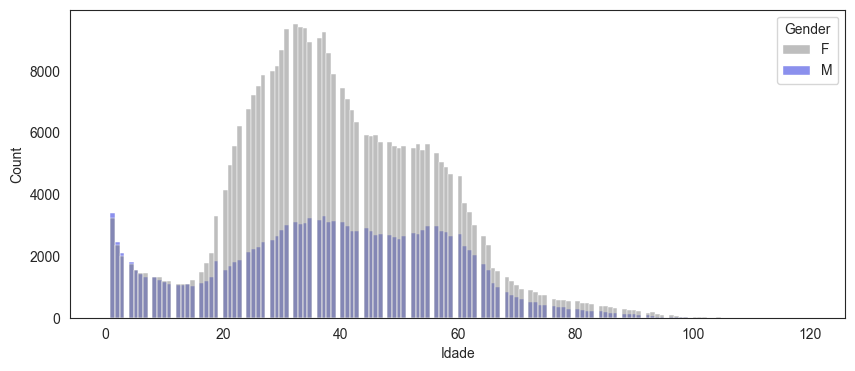

In [16]:
plt.figure(figsize = (10, 4))
sns.set_style('white')
sns.histplot(pacientes_unicos[pacientes_unicos['Idade'] <= 120], x = 'Idade', bins = 150, hue = 'Gender', palette={"M": "#1822DC", "F": "#7f7f7f"})

### O que é o service id? qual a distribuição desta variável?

In [17]:
transactional_data['Service Id'].nunique()

660059

O número de service id diferentes é menor que o total de exames, mas maior que o de clientes únicos. 

tentando observar um padrão nos números pela tabela

In [18]:
transactional_data.head(50)

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Valor Pago,Idade,final_id
0,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,42.0,BIO003
1,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000638,13.0,42.0,BIO003
2,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70001597,49.0,42.0,BIO003
3,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000103,11.0,42.0,BIO003
4,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000224,10.0,42.0,BIO003
5,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70002653,8.0,42.0,BIO003
6,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70001206,41.0,42.0,BIO003
7,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70005903,57.0,42.0,BIO003
8,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000392,8.0,42.0,BIO003
9,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000168,48.0,42.0,BIO003


pelos padrões observados, o service id é o mesmo para um mesmo cliente que realizou vários exames em um mesmo dia. portanto, podemos concluir que o service id é referente à bateria de exames que um cliente faz em um mesmo dia.

com esta informação, é possível investigar qual é o número aproximado de exames que os clientes fazem de cada vez

In [19]:
service_id = transactional_data.groupby('Service Id').count()['Patient Id'].reset_index()

service_id = service_id.rename({'Patient Id': 'Número de exames por bateria'}, axis = 1)

service_id.sort_values('Número de exames por bateria', ascending = False).head()

,Service Id,Número de exames por bateria
269437,6004395771-8-1,87
37661,437707339488-179,85
283211,6169569919-1-1,85
273062,6160868530-2-1,85
422639,7659340080-5-1,81


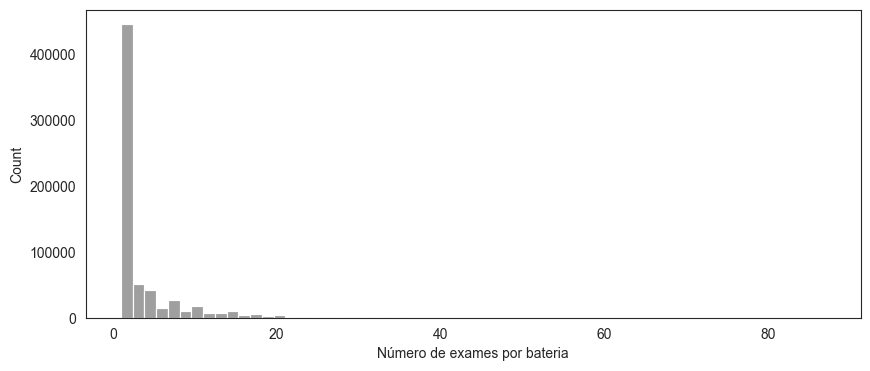

In [20]:
plt.figure(figsize = (10, 4))
sns.set_style('white')
sns.histplot(service_id,#[service_id['Número de exames por bateria'] < 25],
              x = 'Número de exames por bateria', bins = 60, color = '#7f7f7f')
# deixar o gráfico transparente
plt.gcf().set_facecolor('none')
plt.gca().patch.set_alpha(0)

seria interessante verificar se há alguma localidade em que a mediana de exames por bateria se destaca

In [22]:
# juntando a base de transações com o estado, disponível na base df_geocode

transactional_location = transactional_data.merge(df_geocode[['Lab Id', 'Sigla']], how = 'left')

transactional_location.head()

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Valor Pago,Idade,final_id,Sigla
0,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,42.0,BIO003,CA
1,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000638,13.0,42.0,BIO003,CA
2,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70001597,49.0,42.0,BIO003,CA
3,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000103,11.0,42.0,BIO003,CA
4,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000224,10.0,42.0,BIO003,CA


In [23]:
# fazendo a média de exames por bateria por estado

mediana_bateria_estado = transactional_location.groupby(['Sigla', 'Service Id']).count()['Patient Id'].reset_index()

mediana_bateria_estado = mediana_bateria_estado.groupby('Sigla').mean('Patient Id').reset_index()

mediana_bateria_estado.sort_values('Patient Id', ascending = False).reset_index().rename({'Patient Id': 'Média de exames por bateria'}, axis = 1)

,index,Sigla,Média de exames por bateria
0,6,MI,4.195907
1,7,NH,4.134845
2,3,IL,3.912349
3,8,NJ,3.886670
4,1,GA,3.644472
5,5,MA,3.615409
6,10,PA,3.557441
7,2,IA,3.535974
8,9,NY,3.512936
9,12,WA,3.483885


### qual a distribuição do final do código dos pacientes?

não há hipóteses de que esta variável faça diferença para definir a localização, mas vale a pena ver a sua distribuição

In [230]:
pacientes_unicos.value_counts('final_id')

final_id
1          304822
BIO003      91708
BIO002      66762
BIO010      36127
UND2243      1788
UND2113       238
dtype: int64

### há diferença no perfil de sexo ou idade entre os estados?

In [58]:
# qual a mediana geral de idade?

print('mediana de idade geral =', pacientes_unicos.median()['Idade'])
print('mediana de idade das mulheres =', pacientes_unicos[pacientes_unicos['Gender'] == 'F'].median()['Idade'])
print('mediana de idade dos homens =', pacientes_unicos[pacientes_unicos['Gender'] == 'M'].median()['Idade'])

C:\Users\Leticia\AppData\Local\Temp\ipykernel_8020\1080547803.py:3: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



mediana de idade geral = 38.0
mediana de idade das mulheres = 37.0
mediana de idade dos homens = 39.0


C:\Users\Leticia\AppData\Local\Temp\ipykernel_8020\1080547803.py:4: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\Leticia\AppData\Local\Temp\ipykernel_8020\1080547803.py:5: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



C:\Users\Leticia\AppData\Local\Temp\ipykernel_8020\1770038421.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



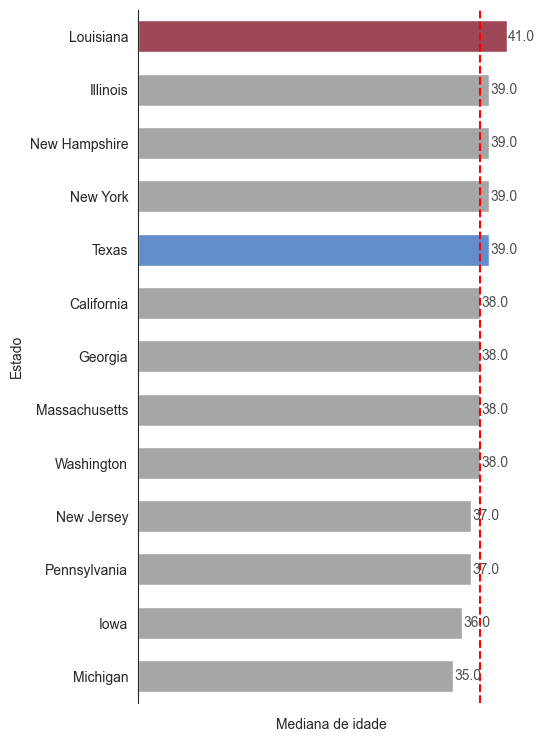

In [71]:
sexo_idade_estado = pacientes_unicos.merge(df_geocode[['Lab Id', 'Sigla']], how = 'left')

sexo_idade_estado = sexo_idade_estado.groupby('Sigla').median()[['Idade']].sort_values('Idade', ascending = False).reset_index()

sexo_idade_estado = sexo_idade_estado.merge(zipcodes_states[['Sigla', 'Estado']], how = 'left')

sexo_idade_estado = sexo_idade_estado.rename({'Idade':"Mediana de idade"}, axis = 1)

cores = ['#ac3a4e' if x == 'Louisiana' else '#5288db' if x == 'Texas' else '#a6a6a6' for x in sexo_idade_estado['Estado']]

plt.figure(figsize = (5,9))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = sexo_idade_estado, x = 'Mediana de idade', y = 'Estado', palette = cores, width = 0.6)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate(i.get_width(),
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 10,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')

# remover as bordas do gráfico
sns.despine(bottom = True)

# adicionar linha vertical em x = 38
plt.axvline(x=38, linestyle='--', color='red')


mesmo gráfico, filtrando apenas as mulheres

C:\Users\Leticia\AppData\Local\Temp\ipykernel_8020\2747701003.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



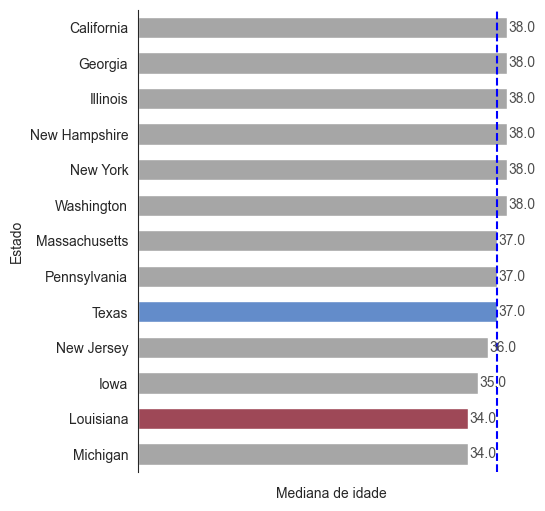

In [68]:
sexo_idade_estado = pacientes_unicos.merge(df_geocode[['Lab Id', 'Sigla']], how = 'left')

sexo_idade_estado = sexo_idade_estado[sexo_idade_estado['Gender'] == 'F'].groupby('Sigla').median()[['Idade']].sort_values('Idade', ascending = False).reset_index()

sexo_idade_estado = sexo_idade_estado.merge(zipcodes_states[['Sigla', 'Estado']], how = 'left')

sexo_idade_estado = sexo_idade_estado.rename({'Idade':"Mediana de idade"}, axis = 1)

cores = ['#ac3a4e' if x == 'Louisiana' else '#5288db' if x == 'Texas' else '#a6a6a6' for x in sexo_idade_estado['Estado']]

plt.figure(figsize = (5,6))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = sexo_idade_estado, x = 'Mediana de idade', y = 'Estado', palette = cores, width = 0.6)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate(i.get_width(),
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 10,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')

# remover as bordas do gráfico
sns.despine(bottom = True)

# adicionar linha vertical em x = 37 (mediana de idade das mulheres)
plt.axvline(x=37, linestyle='--', color='blue')

filtrando agora os homens

C:\Users\Leticia\AppData\Local\Temp\ipykernel_8020\3666205686.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



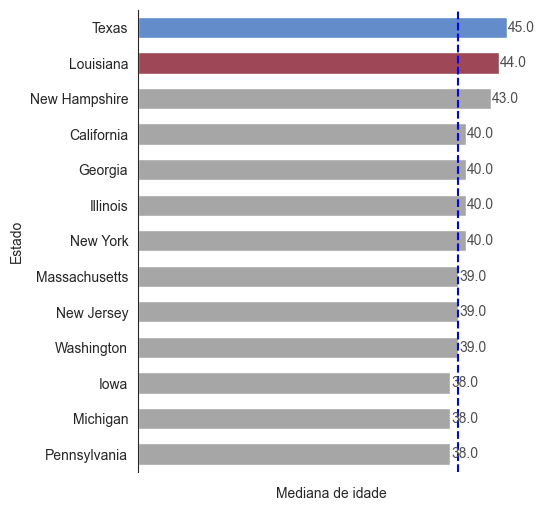

In [72]:
sexo_idade_estado = pacientes_unicos.merge(df_geocode[['Lab Id', 'Sigla']], how = 'left')

sexo_idade_estado = sexo_idade_estado[sexo_idade_estado['Gender'] == 'M'].groupby('Sigla').median()[['Idade']].sort_values('Idade', ascending = False).reset_index()

sexo_idade_estado = sexo_idade_estado.merge(zipcodes_states[['Sigla', 'Estado']], how = 'left')

sexo_idade_estado = sexo_idade_estado.rename({'Idade':"Mediana de idade"}, axis = 1)

cores = ['#ac3a4e' if x == 'Louisiana' else '#5288db' if x == 'Texas' else '#a6a6a6' for x in sexo_idade_estado['Estado']]

plt.figure(figsize = (5,6))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = sexo_idade_estado, x = 'Mediana de idade', y = 'Estado', palette = cores, width = 0.6)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate(i.get_width(),
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 10,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')

# remover as bordas do gráfico
sns.despine(bottom = True)

# adicionar linha vertical em x = 39 (mediana de idade dos homens)
plt.axvline(x=39, linestyle='--', color='blue')

## distribuição das variáveis dos testes e dos laboratórios

### qual é o número de exames por mês do intervalo de dados disponível?

In [130]:
exames_mes = transactional_data

exames_mes['Date of service'] = pd.to_datetime(exames_mes['Date of service'])

exames_mes['mes'] = exames_mes['Date of service'].dt.strftime('%b')
# exames_mes['mes_ordem'] = exames_mes['Date of service'].dt.strftime('%m').astype('int')
exames_mes['ano'] = exames_mes['Date of service'].dt.strftime('%y')

ordem = exames_mes.sort_values('Date of service')[['mes', 'ano']].drop_duplicates()
ordem['mes_ano'] = ordem['mes'] + '/' + ordem['ano']

ordem = ordem.reset_index().reset_index()
ordem = ordem.drop(['index'], axis = 1)
ordem = ordem.rename({'level_0':'mes_ordem'}, axis = 1)
ordem['mes_ordem'] = ordem['mes_ordem'] + 1


In [133]:
exames_mes2 = exames_mes

exames_mes2['mes_ano'] = exames_mes2['mes'] + '/' + exames_mes2['ano']

exames_mes2 = exames_mes2.groupby('mes_ano').count()['CodItem'].reset_index().merge(ordem[['mes_ano', 'mes_ordem']], how = 'left').sort_values('mes_ordem').reset_index()

exames_mes2 = exames_mes2.drop('index', axis = 1)

exames_mes2 = exames_mes2.rename({'CodItem':'Número de exames'}, axis = 1)

exames_mes2.head()

,mes_ano,Número de exames,mes_ordem
0,Jan/19,93203,1
1,Feb/19,84560,2
2,Mar/19,102251,3
3,Apr/19,93955,4
4,May/19,91182,5


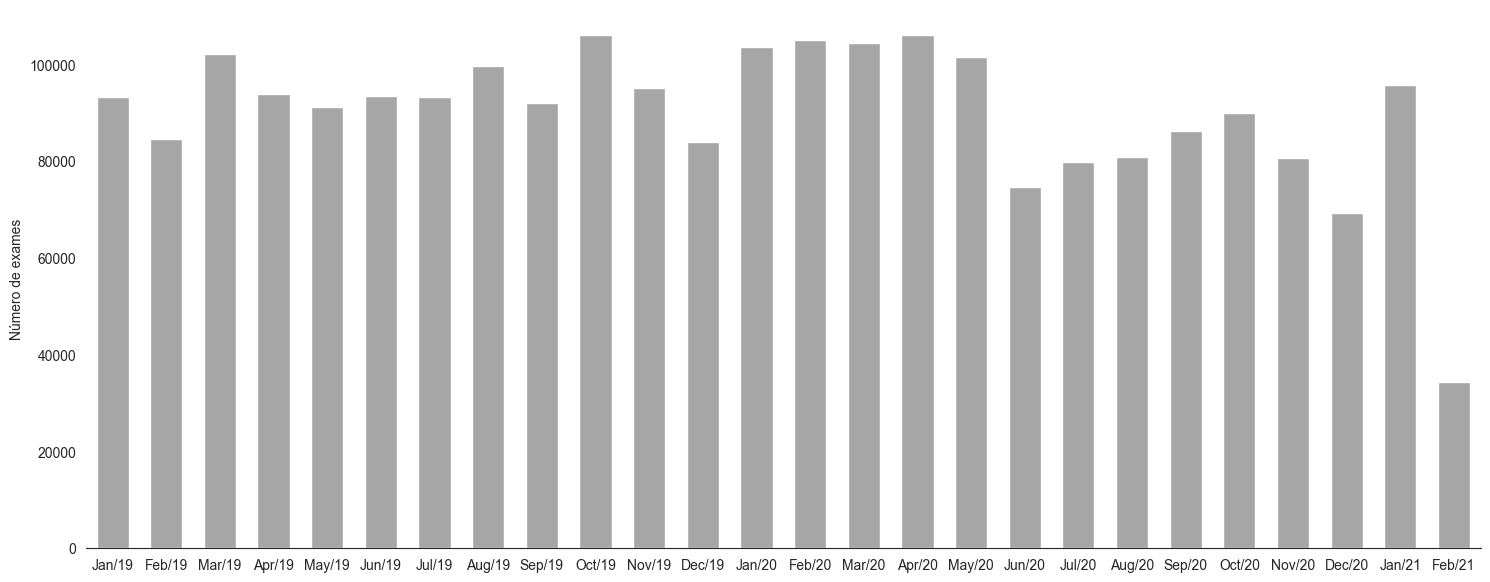

In [134]:
# gráfico

plt.figure(figsize = (18, 7))
sns.set_style('white')
fig = sns.barplot(data = exames_mes2, x = 'mes_ano', y = 'Número de exames', color = '#a6a6a6', width = 0.6)

# remover o título do eixo x
fig.set_xlabel('')

# remover as bordas do gráfico
sns.despine(left = True)

### qual a distribuição dos testes de covid ao longo dos meses?

In [143]:
test_data[test_data['Desc Item'].str.contains('COVID')]

,CodItem,Desc Item,Category,Family,Speciality,Testing Cost


não foram encontrados exames de COVID-19, permitindo a conclusão de que a análise não será enviesada pela pandemia.

### quais são as categorias das outras variáveis dos exames?

In [149]:
test_data.head()

,CodItem,Desc Item,Category,Family,Speciality,Testing Cost
0,70003237,"MAGNESIO, SORO (EXEMPLO DE EXPRESSAO DE RESULT...",CA,CORELAB,BIOCHEMISTRY,1.78
1,70000638,"HEMOGRAMA, AUTOMATIZADO, SANGUE",CA,HEMATO,BLOOD COUNT,2.46
2,70001597,"FERRITINA, SORO",CA,CORELAB,IMMUNOHORMONE,2.11
3,70000103,"FERRO, DOSAGEM, SORO (EXEMPLO DE EXPRESSAO DE ...",CA,CORELAB,BIOCHEMISTRY,0.80
4,70000224,"CALCIO, DOSAGEM, SORO (EXEMPLO DE EXPRESSAO DE...",CA,CORELAB,BIOCHEMISTRY,1.02


In [156]:
## quantas categorias há em cada variável?

print('n categorias Category =', test_data['Category'].nunique())
print('n categorias Family =', test_data['Family'].nunique())
print('n categorias Speciality =', test_data['Speciality'].nunique())

n categorias Category = 6
n categorias Family = 23
n categorias Speciality = 77


há testes que são de graça?

In [196]:
testes_grat = transactional_data[transactional_data['Valor Pago'] == 0]

testes_grat_list = testes_grat[['CodItem']].value_counts()

testes_grat_list


CodItem 
70005139    39134
70006809      267
70006810      232
70006532      217
70002489      205
            ...  
70006933        1
70006936        1
70001660        1
70006937        1
70006932        1
Length: 71, dtype: int64

há 71 tipos de teste que foram de graça. o custo deles também é nulo?

In [198]:
test_data[test_data['CodItem'].isin(testes_grat[['CodItem']].drop_duplicates().reset_index(drop = True)['CodItem'])].sort_values('Testing Cost', ascending = False).head(10)

,CodItem,Desc Item,Category,Family,Speciality,Testing Cost
1678,70007751,"GENE COL2A1, HIPOCONDROGENESE, SEQUENCIAMENTO ...",CA,GENETICS,SPECIAL GENETICS,585.29
1648,70003536,"ESCLEROSE TUBEROSA (TSC1, TSC2), SEQUENCIAMENT...",CA,GENETICS,SPECIAL GENETICS,558.83
1656,70007607,"GENE IDUA, MUCOPOLISSACARIDOSE TIPO 1 - DOENA...",CA,GENETICS,SPECIAL GENETICS,495.87
1640,70005483,"GENE COL1A1, SEQUENCIAMENTO, SANGUE",CA,GENETICS,SPECIAL GENETICS,481.29
1672,70005299,"DISTROFIA MIOTONICA DE STEINERT, SANGUE, ANALI...",CA,GENETICS,SPECIAL GENETICS,479.71
1675,70007550,"GENE (COL3AI), SINDROME EHLERS-DANLOS, TIPO 4,...",CA,GENETICS,SPECIAL GENETICS,424.58
1661,70007750,"OSTEOGENESE IMPERFEITA, PAINEL, SEQUENCIAMENTO...",CA,GENETICS,SPECIAL GENETICS,404.34
1671,70007763,"GENE RET, NEOPLASIA ENDOCRINA MULTIPLA TIPO 2A...",CA,GENETICS,SPECIAL GENETICS,390.98
1653,70007610,"GENE FGFR3, ACONDROPL SICO, SEQUENCIAMENTO (NG...",CA,GENETICS,SPECIAL GENETICS,379.89
1643,70007621,"GENE PTPN11, ESTUDO MOLECULAR SINDROME NOONAN,...",CA,GENETICS,SPECIAL GENETICS,376.81


muitas pessoas fizeram testes de forma gratuita sendo que o custo do teste não é nulo.

esse teste que muita gente fez de graça custa quanto?

In [189]:
test_data[test_data['CodItem'] == 70005139]

,CodItem,Desc Item,Category,Family,Speciality,Testing Cost
40,70005139,"BACTERIAS, ANTIBIOGRAMA AUTOMATIZADO",CA,MICROBIO,CULTURE,7.87


quantos testes são de fato gratuitos?

In [193]:
testes_gratuitos = test_data[test_data['CodItem'].isin(testes_grat.drop_duplicates().reset_index(drop = True)['CodItem'])]

print('número de testes que já foram feitos de graça =', len(testes_gratuitos))
print('número de testes que são de fato de graça =', len(testes_gratuitos[testes_gratuitos['Testing Cost'] == 0]))

número de testes que já foram feitos de graça = 64
número de testes que são de fato de graça = 7


esses testes gratuitos são realizados em algum laboratório em específico?

In [200]:
testes_grat['Lab Id'].value_counts()

L133    2038
L166    1600
L121    1317
L152    1298
L156    1280
        ... 
L660       4
L127       2
L149       1
L665       1
L967       1
Name: Lab Id, Length: 118, dtype: int64

não é em algum específico, todos os laboratórios já realizaram testes gratuitos

qual a distribuição dos valores pagos nos exames?

<Axes: xlabel='Valor Pago', ylabel='Count'>

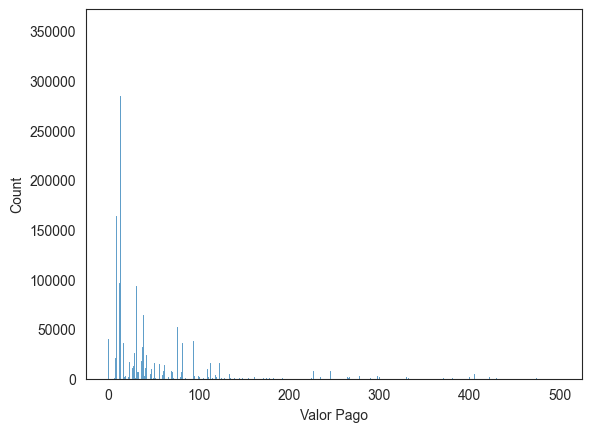

In [202]:
sns.histplot(data = transactional_data[transactional_data['Valor Pago'] < 500], x = 'Valor Pago')

qual a média e a mediana do valor pago nos testes?

In [204]:
print('média do valor pago =', round(transactional_data['Valor Pago'].mean(), 2))
print('mediana do valor pago =', round(transactional_data['Valor Pago'].median(), 2))

média do valor pago = 51.1
mediana do valor pago = 24.0


qual o maior valor já pago em um teste?

In [206]:
transactional_data.sort_values('Valor Pago', ascending = False)['Valor Pago'].reset_index(drop = True).iloc[0]

9500.0

qual o teste mais caro para a empresa?

## distribuição das variáveis dos laboratórios

In [236]:
# em qual laboratório os clientes são mais fidelizados?
transactional_data.groupby(['Patient Id']).count()['Gender'].reset_index().sort_values('Gender', ascending = False)

,Patient Id,Gender
501445,9999999-1,1409
178086,381241267-BIO002,415
248946,7600923838-1,397
250334,7656548765-1,363
300355,7659099707-1,269
...,...,...
337553,7659654240-1,1
75116,10225206037-BIO002,1
337556,7659654249-1,1
337557,7659654274-1,1


## aprofundamentos

### dataframe com a população e o intervalo de zipcodes de cada estado dos EUA

In [108]:
zipcodes_states['População 2020'] = zipcodes_states['População 2020'].apply(lambda x: "".join(x.split())).astype('int')
zipcodes_states['primeiro_zipcode'] = zipcodes_states['Intervalo de CEPs'].apply(lambda x: "".join(x.split())).str.split('to').str[0].astype('float')
zipcodes_states['ultimo_zipcode'] = zipcodes_states['Intervalo de CEPs'].apply(lambda x: "".join(x.split())).str.split('to').str[1].astype('float')

zipcodes_states.sort_values('primeiro_zipcode').head()

,Sigla,Estado,Estado.1,Intervalo de CEPs,Qtd de CEPs,Data de Fundação,População 2020,primeiro_zipcode,ultimo_zipcode
21,MA,Massachusetts,Boston,01001 to 02544,703,"February 6, 1788",7029917,1001.0,2544.0
39,RI,Rhode Island,Providence,02801 to 02940,91,"May 19, 1790",1097379,2801.0,2940.0
29,NH,New Hampshire,Concord,03031 to 03897,284,"June 21, 1788",1377529,3031.0,3897.0
19,ME,Maine,Augusta,03901 to 04992,488,"March 15, 1820",1362359,3901.0,4992.0
45,VT,Vermont,Montpelier,05001 to 05907,309,"March 4, 1791",643077,5001.0,5907.0


In [106]:
merged_df = df_geocode.merge(zipcodes_states[['Estado', 'primeiro_zipcode', 'ultimo_zipcode']], left_on='Zipcode', right_on=lambda x: (zipcodes_states['primeiro_zipcode'] <= x) & (x <= zipcodes_states['ultimo_zipcode']))

merged_df

KeyError: <function <lambda> at 0x00000289324371C0>